In [1]:
!pip install jyro

     |████████████████████████████████| 143kB 2.8MB/s 
     |████████████████████████████████| 92kB 7.0MB/s 
     |████████████████████████████████| 215kB 7.9MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.1.0-cp36-none-any.whl size=88590 sha256=5657ad8454ea9eaecb0f6dad8678b70601864148a4b99435e669e5e97942fc75
  Stored in directory: /root/.cache/pip/wheels/11/5e/47/167d9dfd5fa5850dd0cd3db80afe6db46e620edec3419dce5a
Successfully built cairocffi


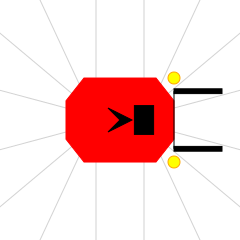

In [2]:
from jyro.simulator import *
import math
robot = Pioneer("Pioneer", 2.50, 4.50, math.pi * 3/2) # meters, radians
robot.addDevice(Pioneer16Sonars())
robot.addDevice(PioneerFrontLightSensors(100))
robot.addDevice(Camera(120, 80))
robot.addDevice(Gripper())

In [0]:
def world(sim):
    sim.addBox(0, 0, 5, 5, fill="backgroundgreen", wallcolor="lightgrey") # meters
    sim.addBox(1, 1, 2, 2, "purple")
    sim.addLight(4, 4, 2.25, color=Color(255, 255, 0, 64))


In [4]:
VSimulator(robot, world, gamepad=True);
robot.brain = lambda self: self.move(1,-1)
robot.getPose()
sim = Simulator(robot, world, gamepad=True)
sim.step(1.70)

In [9]:
from jyro.simulator import (Robot, Pioneer, Pioneer16Sonars, PioneerFrontLightSensors,
                            Camera, Simulator, VSimulator)
import numpy as np
from math import pi
from random import random

vsim = None


def create_robot():
    robot = Pioneer("Pioneer", 2, 1, 5) #paremeters are x, y, heading (in radians)
    robot.addDevice(Camera())
    robot.addDevice(Pioneer16Sonars())
    robot.addDevice(Gripper())
    light_sensors = PioneerFrontLightSensors(3) #parameter defines max range
    robot.addDevice(light_sensors)
    return robot

def create_world(physics):
    physics.addBox(0, 0, 4, 4, fill="backgroundgreen", wallcolor="gray")
    physics.addBox(1.75, 2.9, 2.25, 3.0, fill="blue", wallcolor="blue")
    physics.addBox(1.5, 1.5, 1.6, 2, fill="blue", wallcolor="blue")
    physics.addLight(2, 3.5, 1.0)

def get_senses(robot):
    light = robot["light"].getData()
    sonar = robot["sonar"].getData()
    return [light, sonar]

def random_start(robot):
    robot.setPose(0.5 + random()*2.5, 0.5 + random()*2, random()*2*pi)

def determine_move(senses):
    """Returns tuple of (translation, rotation) movement"""
    lights = senses[0]
    left_light = lights[0]
    right_light = lights[1]
    light_diff = abs(left_light-right_light)
    sonars = senses[1]
    # if found light, then stop
    if sum(lights) > 1.8:
        close_gripper(robot)
        change_light_location()
        return (0, 0)
    # if getting close to an obstacle in front, turn to avoid it
    elif min(sonars[2:6]) < 0.5:
        # if closer on left, turn right
        if min(sonars[1:4]) < min(sonars[4:7]):
            return (0, -0.3)
        # otherwise, turn left
        else:
            return (0, 0.3)
    # if diff in light readings is high enough or total of light readings is
    # low ennough, then turn towards the light
    elif light_diff > 0.1 or sum(lights) < 0.1:
        # if brighter on left side, turn slightly left
        if  left_light > right_light:
            return (0.1, 0.3)
        else:
            return (0.1, -0.3)
    # default is to go straight
    else:
        return (0.3, 0)

def find_light_brain(robot):
    senses = get_senses(robot)
    translate, rotate = determine_move(senses) 
    robot.move(translate, rotate)

def close_gripper(robot):
    a = robot.devices[3]
    a.close()

def change_light_location():
  #print(vsim.physics.lights)
  vsim.physics.lights.pop(0)
  vsim.physics.addLight(1, 1, 1.0)
  vsim.update_gui()

robot = create_robot()
vsim = VSimulator(robot, create_world) #create a visual simulator to watch robot's behavior
random_start(robot)
vsim.update_gui()
robot.brain = find_light_brain


